In [2]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

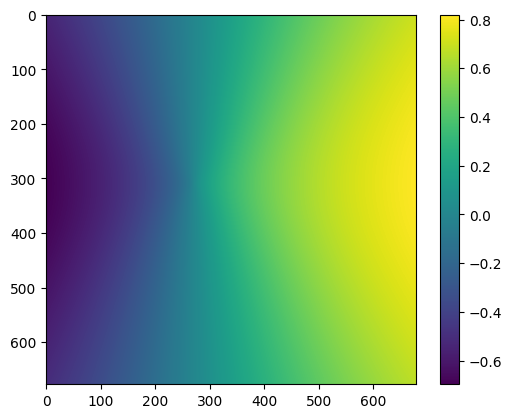

In [73]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['NFW']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'Rs': 10/0.01, 'alpha_Rs': 1/0.01, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()

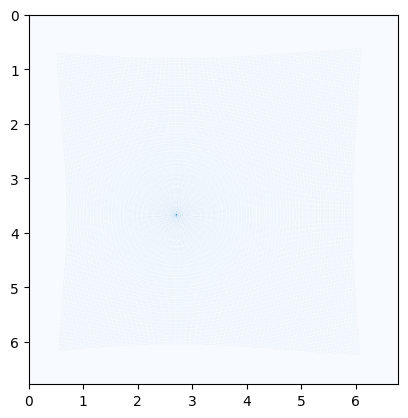

In [74]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [77]:
beta = np.array([2.65, 3.055])/pixscale #in pixel
z_s = 1.5
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)
lensModel = LensModel(lens_model_list=lens_model_list)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_S1 = cosmo.angular_diameter_distance(1.0)
D_S2 = cosmo.angular_diameter_distance(z_s)
D_LS1 = cosmo.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s)
scal = (D_LS1 * D_S2)/(D_LS2 * D_S1)
print(scal)

0.7551897621430999


In [78]:
# lenstronomy
# NFW: how to scal with the source redshift
# the class assume z_s = 1
kwargs_mp = {'Rs': 10, 'alpha_Rs': 1/scal,  'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens = [kwargs_mp]
solver1 = LensEquationSolver(lensModel)
thetax, thetay = solver1.image_position_from_source(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens)
theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i] , thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical, key=lambda x: x[0])  # sort by x coordinate, in arcsec now

# my class
theta_numerical = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)


#plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
#plt.scatter(thetax, thetay, color='red', s=10)
#plt.scatter(beta[0], beta[1], color='green', s=10)
#plt.imshow(array_test, cmap='Blues')
#plt.gca().invert_yaxis()
print(beta * pixscale)



for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    
    print(f'Difference: {np.sqrt((theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')  

[2.65  3.055]
Image 1 position: (2.590602687031902, 3.0015514183373315)
Predicted Image 1 position: [2.46483809 2.88835428]
Difference: 0.1692049862259308


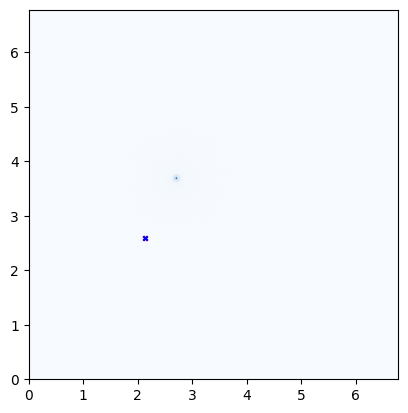

In [67]:
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
for i in range(len(sorted_theta_analytical)):
    plt.scatter(sorted_theta_analytical[i][0], sorted_theta_analytical[i][1], color='red', marker = 'x', s=10)
    plt.scatter(theta_numerical[i][0], theta_numerical[i][1], color='blue', marker = 'x', s=10)
